# Almgren-Chriss Framework – Power-Law Execution Costs

## Objective
Implement the **generalized Almgren-Chriss model** with empirically-calibrated power-law execution costs:
- **Power-law execution costs**: $ L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho| $
- **Empirical calibration**: Based on literature (Almgren et al. 2005, Kyle & Obizhaeva 2016, Bacry et al. 2015)
- **Numerical solution**: Using Hamiltonian characterization from Guéant

This notebook serves as:
- **Realistic implementation** of market impact with power-law costs
- **Empirically grounded** model based on academic literature
- **Comparison** with quadratic baseline
- **Separate analyses** for stock market (AAPL, 6.5h) and cryptocurrency (BTCUSDT, 24h)

---

## Model (Guéant, Chapter 3 - Generalized Almgren-Chriss)

### Price Dynamics (with Linear Permanent Impact)
$$
dS_t = \sigma \, dW_t + k \, v_t \, dt
$$
> $ v_t = \dot{q}_t $: trading speed (shares/day)  
> $ k $: permanent impact coefficient (must be linear to avoid arbitrage - Huberman & Stanzl 2004)  
> $ \sigma $: annualized volatility

### Execution Costs (Temporary / Instantaneous Impact)
$$
L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho|, \quad \rho_t = \frac{|v_t|}{V}
$$

**Empirical values from literature:**
- **φ (power-law exponent)**: Typically 0.4 - 0.7
  - Almgren et al. (2005): ~0.6
  - Kyle & Obizhaeva (2016): ~0.6  
  - Square root law: φ = 0.5 (most popular)
  - Engle et al. (2012): 0.37-0.43
  - Frazzini et al. (2018): ~0.35
- **ψ (proportional costs)**: Bid-ask spread + fees

### Cash Process (for Liquidation, $ q_0 > 0 $)
$$
dX_t = - S_t \, v_t \, dt - V \cdot L\left(\frac{v_t}{V}\right) \, dt
$$

---

### Optimization Objective
Minimize the **risk-adjusted expected implementation shortfall**:
$$
\min_{v_t} \quad \mathbb{E}\left[ X_T \right] + \frac{\lambda}{2} \operatorname{Var}\left[ X_T \right]
$$
> $ \lambda $: risk aversion parameter  
> $ X_T $: final cash after unwinding $ q_0 \to 0 $ over $ [0, T] $

---

### Hamiltonian Characterization (Guéant, Eq. 3.10)
$$
\begin{cases}
p'(t) = \gamma \sigma^2 q^*(t) \\
q^{*'}(t) = V_t H'(p(t)) \\
q^*(0) = q_0 \\
q^*(T) = 0
\end{cases}
$$

where $ H $ is the Legendre-Fenchel transform of $ L $:
$$
H(p) = \sup_{\rho} \left\{ \rho p - L(\rho) \right\}
$$

**For power-law costs** $ L(\rho) = \eta |\rho|^{1+\phi} + \psi |\rho| $ (Guéant, Eq. 3.11):
$$
H(p) = \begin{cases}
0 & \text{if } |p| \leq \psi \\
\frac{\phi}{\eta(1+\phi)} \left(\frac{|p|-\psi}{\eta}\right)^{1 + 1/\phi} & \text{otherwise}
\end{cases}
$$

$$
H'(p) = \begin{cases}
0 & \text{if } |p| \leq \psi \\
\text{sign}(p) \left(\frac{|p|-\psi}{\eta}\right)^{1/\phi} & \text{otherwise}
\end{cases}
$$

> **No closed form** for $ \phi \neq 1 $, requires numerical solution

---

# Setup

In [94]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_bvp
from scipy.optimize import brentq
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Graphics configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print("✅ Imports successful")

✅ Imports successful


In [95]:
# Check data availability
import os

stocks_available = os.path.exists('data/processed/stocks/all_stocks_1m.parquet')
crypto_available = os.path.exists('data/processed/crypto/BTCUSDT_1m.parquet')

# Try to load calibrated parameters
try:
    with open('../results/calibrated_parameters.json', 'r') as f:
        calibrated = json.load(f)
    
    calibrated_available = True
    print("✅ Calibrated parameters loaded from results/calibrated_parameters.json")
    print(f"   Calibrated on: {calibrated.get('timestamp', 'N/A')}")
    print(f"   Symbol: {calibrated.get('symbol', 'N/A')}")
    print(f"   Number of snapshots: {calibrated.get('num_snapshots', 'N/A')}")
    print(f"   Parameters: k={calibrated['parameters']['k']:.8f}, η={calibrated['parameters']['eta']:.6f}, φ={calibrated['parameters']['phi']:.4f}, ψ={calibrated['parameters']['psi']:.6f}")
except FileNotFoundError:
    calibrated_available = False
    print("⚠️ No calibrated parameters found")
    print("   Run notebook 06_parameter_calibration.ipynb first to calibrate parameters")
    print("   Using literature-based parameters as fallback")

print("\nData availability:")
print(f"   Stocks (AAPL): {'✅' if stocks_available else '❌'}")
print(f"   Crypto (BTCUSDT): {'✅' if crypto_available else '❌'}")
print(f"   Calibrated params: {'✅' if calibrated_available else '❌'}")

if not stocks_available and not crypto_available:
    raise Exception("No market data available. Please run notebook 01 first to collect data.")

✅ Calibrated parameters loaded from results/calibrated_parameters.json
   Calibrated on: 2025-12-06T23:20:25.496384
   Symbol: BTCUSDT
   Number of snapshots: 360
   Parameters: k=0.00000555, η=0.452225, φ=0.2079, ψ=0.000050

Data availability:
   Stocks (AAPL): ❌
   Crypto (BTCUSDT): ✅
   Calibrated params: ✅


## Class AlmgrenChrissPowerLaw

Implementation of the generalized model with power-law execution costs, based on Guéant's Hamiltonian characterization (Chapter 3).

In [96]:
class AlmgrenChrissPowerLaw:
    """
    Almgren-Chriss generalized model with power-law execution costs.
    
    Cost function: L(ρ) = η|ρ|^(1+φ) + ψ|ρ|
    where ρ = v/V is the participation rate.
    
    Reference: Guéant, "Financial Mathematics of Market Liquidity", Chapter 3
    Empirical calibration: Almgren et al. (2005), Kyle & Obizhaeva (2016)
    """
    
    def __init__(self, 
                 lambda_risk: float,  # Risk aversion λ
                 sigma: float,        # Volatility
                 k: float,            # Permanent impact
                 phi: float,          # Power exponent
                 eta: float,          # Execution cost coeff
                 psi: float,          # Proportional costs
                 V: float):           # Market volume
        
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.phi = phi
        self.eta = eta
        self.psi = psi
        self.V = V
    
    def L(self, rho):
        """
        Execution cost function: L(ρ) = η|ρ|^(1+φ) + ψ|ρ|
        """
        return self.eta * np.abs(rho)**(1 + self.phi) + self.psi * np.abs(rho)
    
    def H_prime(self, p):
        """
        Derivative of Legendre-Fenchel transform H'(p).
        
        From Guéant Eq. 3.11:
        H'(p) = { 0                           if |p| ≤ ψ
                { sign(p) * ((|p|-ψ)/η)^(1/φ)  otherwise
        
        Vectorized to handle both scalars and arrays (needed for solve_bvp).
        """
        # Ensure p is array for vectorized operations
        p_array = np.atleast_1d(p)
        abs_p = np.abs(p_array)
        sign_p = np.sign(p_array)
        
        # Initialize result (dead zone = 0)
        result = np.zeros_like(p_array, dtype=float)
        
        # Active zone: |p| > ψ
        # For very small ψ (e.g., calibrated ψ = 0.00005), use small threshold
        threshold = max(self.psi, 1e-8)
        mask = abs_p > threshold
        
        if np.any(mask):
            result[mask] = sign_p[mask] * ((abs_p[mask] - self.psi) / self.eta)**(1.0 / self.phi)
        
        # Return scalar if input was scalar, otherwise array
        return result.item() if p_array.shape == (1,) else result
    
    def hamiltonian_system(self, t, y):
        """
        Hamiltonian system for optimal trajectory.
        
        y = [q, p] where q is position and p is dual variable.
        
        System (Guéant Eq. 3.10):
        q'(t) = V * H'(p(t))
        p'(t) = γσ² * q(t)
        """
        q, p = y
        
        # H_prime now handles arrays properly
        dq_dt = self.V * self.H_prime(p)
        dp_dt = self.lambda_risk * self.sigma**2 * q
        
        return np.vstack([dq_dt, dp_dt])
    
    def boundary_conditions(self, ya, yb, q0):
        """
        Boundary conditions: q(0) = q0, q(T) = 0
        """
        return np.array([ya[0] - q0, yb[0]])
    
    def optimal_trajectory(self, 
                           q0: float, 
                           T: float, 
                           N: int = 390) -> tuple:
        """
        Compute optimal trajectory via BVP solver.
        
        Returns: t, q_star, v_star
        
        Special handling for small ψ (calibrated parameters):
        When ψ is very small (< 0.0001), the solver needs better initialization
        to avoid singular Jacobian in the dead zone.
        """
        
        # Use fewer points for initial solve to avoid singularity
        N_init = min(100, N)
        t_guess = np.linspace(0, T, N_init)
        q_guess = q0 * (1 - t_guess / T)
        
        # Better initial guess for p using quadratic model as starting point
        gamma = self.lambda_risk * self.sigma**2
        kappa_approx = np.sqrt(gamma * self.V / (2 * self.eta))
        
        # For very small ψ (calibrated params), use larger initial p to avoid dead zone
        if self.psi < 0.0001:
            # Start well above the dead zone threshold
            p_scale = max(100 * self.psi, 0.01)
        else:
            p_scale = self.psi * 3
        
        # Initial guess for p should decay exponentially
        p_guess = p_scale * np.exp(-kappa_approx * t_guess)
        
        y_guess = np.vstack([q_guess, p_guess])
        
        # Try multiple strategies with increasing tolerance
        strategies = [
            {'tol': 1e-6, 'max_nodes': 5000},
            {'tol': 1e-5, 'max_nodes': 10000},
            {'tol': 1e-4, 'max_nodes': 15000},
        ]
        
        sol = None
        for strategy in strategies:
            try:
                sol = solve_bvp(
                    lambda t, y: self.hamiltonian_system(t, y),
                    lambda ya, yb: self.boundary_conditions(ya, yb, q0),
                    t_guess,
                    y_guess,
                    tol=strategy['tol'],
                    max_nodes=strategy['max_nodes'],
                    verbose=0
                )
                
                if sol.success:
                    break
            except Exception as e:
                continue
        
        # If still not successful, try with linear p guess
        if sol is None or not sol.success:
            # Linear decay for p, starting well above threshold
            p_guess_linear = np.linspace(p_scale, p_scale * 0.1, N_init)
            y_guess_alt = np.vstack([q_guess, p_guess_linear])
            
            sol = solve_bvp(
                lambda t, y: self.hamiltonian_system(t, y),
                lambda ya, yb: self.boundary_conditions(ya, yb, q0),
                t_guess,
                y_guess_alt,
                tol=1e-4,
                max_nodes=15000,
                verbose=0
            )
        
        if not sol.success:
            # Last resort: use quadratic approximation when ψ is very small
            if self.psi < 0.0001:
                print(f"   ⚠️ BVP solver struggled with small ψ={self.psi:.6f}")
                print(f"      Using quadratic approximation (ignoring ψ term)")
                
                # Quadratic model without ψ term
                kappa = np.sqrt(gamma * self.V / (2 * self.eta))
                t = np.linspace(0, T, N+1)
                q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
                v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
                
                return t, q_star, v_star
            else:
                raise RuntimeError(f"BVP solver failed: {sol.message if sol else 'No solution found'}")
        
        # Evaluate on fine grid
        t = np.linspace(0, T, N+1)
        y = sol.sol(t)
        q_star = y[0]
        p_star = y[1]
        
        # Compute velocity v = dq/dt = V * H'(p)
        v_star = self.V * self.H_prime(p_star)
        
        return t, q_star, v_star
    
    def compute_costs(self, 
                      q0: float, 
                      T: float, 
                      N: int,
                      strategy: str = 'optimal') -> dict:
        """
        Compute costs for given strategy.
        
        - Execution cost: ∫ V·L(v/V) dt
        - Permanent impact: k·|q0| / 2
        - Price risk: (λ/2)·σ²·∫ q² dt
        """
        
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T, N)
        elif strategy in ['twap', 'vwap']:
            t = np.linspace(0, T, N+1)
            q = q0 * (1 - t / T) if q0 > 0 else q0 * (t / T - 1)
            v = -(q0 / T) * np.ones_like(t) if q0 > 0 else (abs(q0) / T) * np.ones_like(t)
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        dt = T / N
        
        # Execution cost: ∫ V·L(v/V) dt
        rho = v / self.V
        L_values = np.array([self.L(r) for r in rho[:-1]])
        execution_cost = np.sum(self.V * L_values * dt)
        
        # Permanent impact
        permanent_impact = self.k * abs(q0) / 2
        
        # Price risk
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        
        total_cost = execution_cost + permanent_impact + timing_risk
        
        return {
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'timing_risk_variance': timing_risk_variance,
            'total_cost': total_cost
        }
    
    def compute_expected_shortfall(self, 
                                   q0: float, 
                                   T: float,
                                   N: int,
                                   S0: float = 100.0) -> dict:
        """
        Implementation Shortfall: Total cost * S0 in € and bps.
        """
        costs = self.compute_costs(q0, T, N, 'optimal')
        shortfall_euros = costs['total_cost'] * S0
        notional = abs(q0) * S0
        shortfall_bps = (shortfall_euros / notional) * 10000
        
        return {
            'shortfall_euros': shortfall_euros,
            'shortfall_bps': shortfall_bps,
            'breakdown': costs
        }

print("✅ Class AlmgrenChrissPowerLaw defined")

✅ Class AlmgrenChrissPowerLaw defined


## Class AlmgrenChrissQuadratic (Baseline)

Quadratic model for comparison with power-law model.

In [97]:
# Quadratic model (baseline) - for comparison
class AlmgrenChrissQuadratic:
    """Baseline quadratic model for comparison."""
    
    def __init__(self, lambda_risk, sigma, k, eta, V):
        self.lambda_risk = lambda_risk
        self.sigma = sigma
        self.k = k
        self.eta = eta
        self.V = V
    
    def compute_kappa(self):
        return np.sqrt(self.lambda_risk * self.sigma**2 * self.V / (2 * self.eta))
    
    def optimal_trajectory(self, q0, T, N=390):
        kappa = self.compute_kappa()
        t = np.linspace(0, T, N+1)
        q_star = q0 * np.sinh(kappa * (T - t)) / np.sinh(kappa * T)
        v_star = q0 * (-kappa) * np.cosh(kappa * (T - t)) / np.sinh(kappa * T)
        return t, q_star, v_star
    
    def compute_costs(self, q0, T, N, strategy='optimal'):
        if strategy == 'optimal':
            t, q, v = self.optimal_trajectory(q0, T, N)
        else:
            t = np.linspace(0, T, N+1)
            q = q0 * (1 - t / T)
            v = -(q0 / T) * np.ones_like(t)
        
        dt = T / N
        rho = np.abs(v) / self.V
        execution_cost = np.sum(self.eta * rho[:-1]**2 * dt)
        permanent_impact = self.k * abs(q0) / 2
        timing_risk_variance = self.sigma**2 * np.sum(q[:-1]**2 * dt)
        timing_risk = (self.lambda_risk / 2) * timing_risk_variance
        total_cost = execution_cost + permanent_impact + timing_risk
        
        return {
            'execution_cost': execution_cost,
            'permanent_impact': permanent_impact,
            'timing_risk': timing_risk,
            'total_cost': total_cost
        }

print("✅ Baseline class defined")

✅ Baseline class defined


---

# Part 1: Stock Market Analysis (AAPL, 6.5 hours)

Analysis of the power-law Almgren-Chriss model applied to stock market data (AAPL).  
Trading day: **6.5 hours** (390 minutes, 9:30 AM - 4:00 PM ET)

## 1.1 Parameters for Stocks

In [98]:
if stocks_available:
    # Load stock data
    df_market_stock = pd.read_parquet('data/processed/stocks/all_stocks_1m.parquet')
    TICKER_STOCK = 'AAPL'
    data_stock = df_market_stock[df_market_stock['ticker'] == TICKER_STOCK]
    
    print(f"✅ Stock data loaded for {TICKER_STOCK}")
    print(f"   Period: {data_stock.index.min()} → {data_stock.index.max()}")
    print(f"   Number of rows: {len(data_stock):,}")
    
    # Load parameters
    df_params = pd.read_parquet('data/processed/market_parameters.parquet')
    params_stock = df_params[
        (df_params['symbol'] == TICKER_STOCK) & 
        (df_params['asset_type'] == 'stock')
    ].iloc[0]
    
    sigma_stock = params_stock['vol_annual']
    V_stock = params_stock['volume_per_day']
    S0_stock = data_stock['close'].iloc[-1]
    
    print(f"\n✅ Parameters loaded for {TICKER_STOCK} (stock):")
    print(f"   σ = {sigma_stock:.4f} ({sigma_stock*100:.1f}% annualized)")
    print(f"   V = {V_stock:,.0f} shares/day")
    print(f"   S₀ = ${S0_stock:.2f}")
    
    # LITERATURE-BASED PARAMETERS FOR POWER-LAW MODEL
    print("\n🔬 Empirical parameters from literature:")
    
    k_stock = 0.0025
    print(f"   k (permanent impact)    = {k_stock:.6f} [linear, no-arbitrage]")
    
    phi_stock = 0.5  # Square root law
    print(f"   φ (power exponent)      = {phi_stock} [square root, Almgren+ 2005]")
    
    eta_stock = 0.10
    print(f"   η (cost coefficient)    = {eta_stock}")
    
    psi_stock = 0.002  # Proportional costs
    print(f"   ψ (proportional costs)  = {psi_stock} = {psi_stock*10000:.0f} bps [spread + fees]")
    
    lambda_risk_stock = 5e-6
    print(f"   λ (risk aversion)       = {lambda_risk_stock:.6f}")
    
    # EXECUTION SCENARIO - STOCKS
    q0_stock = 200_000  # 200k shares
    T_stock = 1.0  # 1 day
    N_stock = 390  # 6.5 hours = 390 minutes
    
    print(f"\n🎯 Execution scenario (unwinding to q_T=0):")
    print(f"   q₀ = {q0_stock:,} shares")
    print(f"   T  = {T_stock} day (390 minutes, 6.5 hours)")
    print(f"   S₀ = ${S0_stock:.2f}")
    print(f"   Notional = ${abs(q0_stock)*S0_stock:,.0f}")
    
    print("\n" + "="*70 + "\n")
    
    params_stock_dict = {
        'sigma': sigma_stock,
        'V': V_stock,
        'k': k_stock,
        'phi': phi_stock,
        'eta': eta_stock,
        'psi': psi_stock,
        'lambda_risk': lambda_risk_stock,
        'q0': q0_stock,
        'T': T_stock,
        'N': N_stock,
        'S0': S0_stock
    }
    print("📋 Summary of parameters (stocks):")
    for key, val in params_stock_dict.items():
        if isinstance(val, float) and val < 0.01:
            print(f"   {key:12s} = {val:.6f}")
        elif isinstance(val, float):
            print(f"   {key:12s} = {val:,.4f}")
        else:
            print(f"   {key:12s} = {val:,}")
else:
    print("❌ Stock data not available - skipping stock analysis")

❌ Stock data not available - skipping stock analysis


## 1.2 Optimal Trajectory for Stocks

In [99]:
if stocks_available:
    # Instantiate models for stocks
    model_quad_stock = AlmgrenChrissQuadratic(
        lambda_risk=params_stock_dict['lambda_risk'],
        sigma=params_stock_dict['sigma'],
        k=params_stock_dict['k'],
        eta=params_stock_dict['eta'],
        V=params_stock_dict['V']
    )
    
    model_power_stock = AlmgrenChrissPowerLaw(
        lambda_risk=params_stock_dict['lambda_risk'],
        sigma=params_stock_dict['sigma'],
        k=params_stock_dict['k'],
        phi=params_stock_dict['phi'],
        eta=params_stock_dict['eta'],
        psi=params_stock_dict['psi'],
        V=params_stock_dict['V']
    )
    
    print("✅ Models instantiated for stocks")

In [100]:
if stocks_available:
    # Calculate trajectories for stocks
    print("Calculating optimal trajectories for stocks...")
    
    t_quad_stock, q_quad_stock, v_quad_stock = model_quad_stock.optimal_trajectory(
        q0_stock, T_stock, N_stock
    )
    print("✅ Quadratic model: trajectory computed")
    
    t_power_stock, q_power_stock, v_power_stock = model_power_stock.optimal_trajectory(
        q0_stock, T_stock, N_stock
    )
    print("✅ Power-law model: trajectory computed")
    
    # TWAP for reference
    t_twap_stock = np.linspace(0, T_stock, N_stock+1)
    q_twap_stock = q0_stock * (1 - t_twap_stock / T_stock)
    v_twap_stock = -(q0_stock / T_stock) * np.ones_like(t_twap_stock)
    
    print("\nTrajectory statistics (stocks):")
    print("\nQuadratic model:")
    print(f"   Initial velocity: {v_quad_stock[0]:,.0f} shares/day")
    print(f"   Final velocity: {v_quad_stock[-1]:,.0f} shares/day")
    print(f"   Initial participation: {abs(v_quad_stock[0])/V_stock*100:.2f}%")
    print(f"   Final participation: {abs(v_quad_stock[-1])/V_stock*100:.2f}%")
    
    print(f"\nPower-law model (φ={phi_stock:.1f}): ")
    print(f"   Initial velocity: {v_power_stock[0]:,.0f} shares/day")
    print(f"   Final velocity: {v_power_stock[-1]:,.0f} shares/day")
    print(f"   Initial participation: {abs(v_power_stock[0])/V_stock*100:.2f}%")
    print(f"   Final participation: {abs(v_power_stock[-1])/V_stock*100:.2f}%")
    
    print("\nTWAP (reference):")
    print(f"   Constant velocity: {v_twap_stock[0]:,.0f} shares/day")
    print(f"   Participation: {abs(v_twap_stock[0])/V_stock*100:.2f}%")

## 1.3 Visualizations for Stocks

In [101]:
if stocks_available:
    # Visualization of trajectories for stocks
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Stock Market Analysis - {TICKER_STOCK} (6.5 hour trading day)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Position q(t)
    ax = axes[0, 0]
    ax.plot(t_twap_stock * 390, q_twap_stock / 1000, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_stock * 390, q_quad_stock / 1000, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_stock * 390, q_power_stock / 1000, '-', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_stock})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position q(t) (thousands of shares)')
    ax.set_title('Optimal Position Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Velocity v(t)
    ax = axes[0, 1]
    ax.plot(t_twap_stock * 390, v_twap_stock / 1000, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_stock * 390, v_quad_stock / 1000, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_stock * 390, v_power_stock / 1000, '-', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_stock})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity v(t) (thousands of shares/day)')
    ax.set_title('Optimal Trading Velocities')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Participation rate |v|/V
    ax = axes[1, 0]
    ax.plot(t_twap_stock * 390, np.abs(v_twap_stock) / V_stock * 100, '--', 
            color='gray', linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_stock * 390, np.abs(v_quad_stock) / V_stock * 100, '-', 
            color='tab:blue', linewidth=2.5, label='Quadratic')
    ax.plot(t_power_stock * 390, np.abs(v_power_stock) / V_stock * 100, '-', 
            color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi_stock})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Participation rate (%)')
    ax.set_title('Market Participation Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Difference between models
    ax = axes[1, 1]
    diff_position_stock = (q_power_stock - q_quad_stock) / 1000
    ax.plot(t_power_stock * 390, diff_position_stock, '-', color='tab:green', linewidth=2.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position difference (thousands)')
    ax.set_title(f'Gap: Power-law (φ={phi_stock}) - Quadratic')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 1.4 Cost Analysis for Stocks

In [102]:
if stocks_available:
    # Calculate costs for stocks
    print("Computing costs for stocks...\n")
    
    costs_quad_opt_stock = model_quad_stock.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
    costs_quad_twap_stock = model_quad_stock.compute_costs(q0_stock, T_stock, N_stock, 'twap')
    
    costs_power_opt_stock = model_power_stock.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
    costs_power_twap_stock = model_power_stock.compute_costs(q0_stock, T_stock, N_stock, 'twap')
    
    # Create comparison DataFrame
    costs_comparison_stock = pd.DataFrame({
        'Quadratic\nOptimal': [
            costs_quad_opt_stock['execution_cost'] * S0_stock,
            costs_quad_opt_stock['permanent_impact'] * S0_stock,
            costs_quad_opt_stock['timing_risk'] * S0_stock,
            costs_quad_opt_stock['total_cost'] * S0_stock
        ],
        'Quadratic\nTWAP': [
            costs_quad_twap_stock['execution_cost'] * S0_stock,
            costs_quad_twap_stock['permanent_impact'] * S0_stock,
            costs_quad_twap_stock['timing_risk'] * S0_stock,
            costs_quad_twap_stock['total_cost'] * S0_stock
        ],
        f'Power-law (φ={phi_stock})\nOptimal': [
            costs_power_opt_stock['execution_cost'] * S0_stock,
            costs_power_opt_stock['permanent_impact'] * S0_stock,
            costs_power_opt_stock['timing_risk'] * S0_stock,
            costs_power_opt_stock['total_cost'] * S0_stock
        ],
        f'Power-law (φ={phi_stock})\nTWAP': [
            costs_power_twap_stock['execution_cost'] * S0_stock,
            costs_power_twap_stock['permanent_impact'] * S0_stock,
            costs_power_twap_stock['timing_risk'] * S0_stock,
            costs_power_twap_stock['total_cost'] * S0_stock
        ]
    }, index=['Execution (€)', 'Permanent impact (€)', 'Timing risk (€)', 'Total (€)'])
    
    print("Cost comparison for stocks (in euros):")
    print(costs_comparison_stock.round(2))
    
    # Costs in bps
    notional_stock = abs(q0_stock) * S0_stock
    costs_bps_stock = costs_comparison_stock / notional_stock * 10000
    print("\nCost comparison for stocks (in bps):")
    print(costs_bps_stock.round(2))

In [103]:
if stocks_available:
    # Visualization of costs for stocks
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Stock Market Cost Analysis - {TICKER_STOCK}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Costs in euros
    ax = axes[0]
    costs_comparison_stock.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Cost Breakdown (€)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cost (€)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    # 2. Costs in bps
    ax = axes[1]
    costs_bps_stock.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Cost Breakdown (bps)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cost (bps)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Optimization gains vs TWAP
    print("\nOptimization gains for stocks (Optimal vs TWAP):")
    gain_quad_stock = (costs_quad_twap_stock['total_cost'] - costs_quad_opt_stock['total_cost']) / costs_quad_twap_stock['total_cost'] * 100
    gain_power_stock = (costs_power_twap_stock['total_cost'] - costs_power_opt_stock['total_cost']) / costs_power_twap_stock['total_cost'] * 100
    
    print(f"   Quadratic model: {gain_quad_stock:.2f}%")
    print(f"   Power-law model (φ={phi_stock}): {gain_power_stock:.2f}%")
    
    # Difference between models
    print("\nDifference between models for stocks (Optimal):")
    diff_total_stock = (costs_power_opt_stock['total_cost'] - costs_quad_opt_stock['total_cost']) / costs_quad_opt_stock['total_cost'] * 100
    diff_exec_stock = (costs_power_opt_stock['execution_cost'] - costs_quad_opt_stock['execution_cost']) / costs_quad_opt_stock['execution_cost'] * 100
    
    print(f"   Total cost: {diff_total_stock:+.2f}%")
    print(f"   Execution cost: {diff_exec_stock:+.2f}%")

## 1.5 Sensitivity Analysis on φ for Stocks

In [104]:
if stocks_available:
    # Test different values of φ for stocks
    phi_values = [0.3, 0.4, 0.5, 0.6, 0.7, 1.0]  # 1.0 = quadratic
    results_phi_stock = []
    
    print("Sensitivity analysis on φ for stocks...\n")
    
    for phi_test in phi_values:
        print(f"   Computing for φ = {phi_test}...")
        
        model_test = AlmgrenChrissPowerLaw(
            lambda_risk=params_stock_dict['lambda_risk'],
            sigma=params_stock_dict['sigma'],
            k=params_stock_dict['k'],
            phi=phi_test,
            eta=params_stock_dict['eta'],
            psi=params_stock_dict['psi'],
            V=params_stock_dict['V']
        )
        
        try:
            t_test, q_test, v_test = model_test.optimal_trajectory(q0_stock, T_stock, N_stock)
            costs_test = model_test.compute_costs(q0_stock, T_stock, N_stock, 'optimal')
            
            results_phi_stock.append({
                'phi': phi_test,
                'v_initial': v_test[0],
                'v_final': v_test[-1],
                'participation_initial': abs(v_test[0]) / V_stock * 100,
                'participation_final': abs(v_test[-1]) / V_stock * 100,
                'execution_cost': costs_test['execution_cost'] * S0_stock,
                'total_cost': costs_test['total_cost'] * S0_stock,
                'total_cost_bps': costs_test['total_cost'] / abs(q0_stock) * 10000
            })
        except Exception as e:
            print(f"      Failed for φ = {phi_test}: {str(e)}")
    
    df_phi_stock = pd.DataFrame(results_phi_stock)
    
    print("\nResults for stocks:")
    print(df_phi_stock[['phi', 'participation_initial', 'participation_final', 'total_cost_bps']].round(2))

In [105]:
if stocks_available:
    # Sensitivity visualization for stocks
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Sensitivity Analysis on φ - {TICKER_STOCK} (Stocks)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Initial participation vs φ
    ax = axes[0]
    ax.plot(df_phi_stock['phi'], df_phi_stock['participation_initial'], 'o-', linewidth=2.5, markersize=8)
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial participation (%)', fontsize=12)
    ax.set_title('Impact of φ on Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Total cost vs φ
    ax = axes[1]
    ax.plot(df_phi_stock['phi'], df_phi_stock['total_cost_bps'], 'o-', linewidth=2.5, markersize=8, color='tab:orange')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Total cost (bps)', fontsize=12)
    ax.set_title('Impact of φ on Total Cost', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Initial/final participation ratio vs φ
    ax = axes[2]
    ratio_stock = df_phi_stock['participation_initial'] / df_phi_stock['participation_final']
    ax.plot(df_phi_stock['phi'], ratio_stock, 'o-', linewidth=2.5, markersize=8, color='tab:green')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial/final ratio', fontsize=12)
    ax.set_title('Relative Aggressiveness of Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nObservations for stocks:")
    print(f"   - Smaller φ → More aggressive front-loading (higher initial participation)")
    print(f"   - φ = 0.5 (square root): Empirically validated compromise")
    print(f"   - φ = 1.0 (quadratic): Classical Almgren-Chriss model")

---

# Part 2: Cryptocurrency Analysis (BTCUSDT, 24 hours)

Analysis of the power-law Almgren-Chriss model applied to cryptocurrency market data (BTCUSDT).  
Trading day: **24 hours** (1440 minutes, continuous trading)

## 2.1 Parameters for Crypto

**Sources de paramètres** :
- **σ, V, S₀** : Calculés à partir des données historiques (notebook 01)
- **k, η, φ, ψ** : 
  - ✅ **Si disponible** : Paramètres calibrés empiriquement sur order book réel (notebook 06)
  - ⚠️ **Sinon** : Valeurs génériques de la littérature académique

**Pourquoi calibrer ?**
- Les paramètres de littérature sont **génériques** et proviennent d'études sur d'autres marchés
- Les paramètres calibrés sont **spécifiques** au marché BTCUSDT et reflètent sa microstructure réelle
- La calibration améliore significativement la **précision** des prédictions de coûts

In [106]:
if crypto_available:
    # Load crypto data
    SYMBOL_CRYPTO = 'BTCUSDT'
    df_crypto = pd.read_parquet(f'data/processed/crypto/{SYMBOL_CRYPTO}_1m.parquet')
    
    print(f"✅ Crypto data loaded for {SYMBOL_CRYPTO}")
    print(f"   Period: {df_crypto['timestamp'].min()} → {df_crypto['timestamp'].max()}")
    print(f"   Number of rows: {len(df_crypto):,}")
    
    # Load parameters
    df_params = pd.read_parquet('data/processed/market_parameters.parquet')
    params_crypto = df_params[
        (df_params['symbol'] == SYMBOL_CRYPTO) & 
        (df_params['asset_type'] == 'crypto')
    ].iloc[0]
    
    sigma_crypto = params_crypto['vol_annual']
    V_crypto = params_crypto['volume_per_day']
    S0_crypto = df_crypto['close'].iloc[-1]
    
    print(f"\n✅ Parameters loaded for {SYMBOL_CRYPTO} (crypto):")
    print(f"   σ = {sigma_crypto:.4f} ({sigma_crypto*100:.1f}% annualized)")
    print(f"   V = {V_crypto:,.0f} units/day")
    print(f"   S₀ = ${S0_crypto:.2f}")
    
    # Use CALIBRATED parameters if available, otherwise use literature values
    if calibrated_available and calibrated.get('symbol') == SYMBOL_CRYPTO:
        print("\n🎯 Using CALIBRATED parameters from order book:")
        
        k_crypto = calibrated['parameters']['k']
        phi_crypto = calibrated['parameters']['phi']
        eta_crypto = calibrated['parameters']['eta']
        psi_crypto = calibrated['parameters']['psi']
        
        print(f"   k (permanent impact)    = {k_crypto:.8f} [calibrated, Kyle's lambda]")
        print(f"   φ (power exponent)      = {phi_crypto:.4f} [calibrated]")
        print(f"   η (cost coefficient)    = {eta_crypto:.6f} [calibrated]")
        print(f"   ψ (proportional costs)  = {psi_crypto:.6f} = {psi_crypto*10000:.2f} bps [effective spread]")
        
        print(f"\n   📊 Calibration quality:")
        print(f"      R² (Kyle's lambda): {calibrated['goodness_of_fit']['kyle_r_squared']:.4f}")
        if calibrated['goodness_of_fit'].get('powerlaw_r_squared'):
            print(f"      R² (power-law):     {calibrated['goodness_of_fit']['powerlaw_r_squared']:.4f}")
        
        print(f"\n   ⚠️ Note about φ = {phi_crypto:.2f}:")
        if phi_crypto < 0.3:
            print(f"      φ is below typical range [0.3-0.7]")
            print(f"      This suggests nearly linear impact for BTCUSDT")
        elif phi_crypto > 0.7:
            print(f"      φ is above typical range [0.3-0.7]")
            print(f"      This suggests more concave impact")
        else:
            print(f"      ✅ φ is within expected range [0.3-0.7]")
    else:
        print("\n📚 Using LITERATURE-BASED parameters (fallback):")
        
        k_crypto = 0.0025
        print(f"   k (permanent impact)    = {k_crypto:.6f} [linear, no-arbitrage]")
        
        phi_crypto = 0.5  # Square root law
        print(f"   φ (power exponent)      = {phi_crypto} [square root, Almgren+ 2005]")
        
        eta_crypto = 0.10
        print(f"   η (cost coefficient)    = {eta_crypto}")
        
        psi_crypto = 0.002  # Proportional costs
        print(f"   ψ (proportional costs)  = {psi_crypto} = {psi_crypto*10000:.0f} bps [spread + fees]")
        
        print(f"\n   ⚠️ These are generic values from literature")
        print(f"      Run notebook 06 to calibrate on real order book data for accuracy")
    
    lambda_risk_crypto = 5e-6
    print(f"\n   λ (risk aversion)       = {lambda_risk_crypto:.6f}")
    
    # EXECUTION SCENARIO - CRYPTO
    q0_crypto = 100  # 100 BTC
    T_crypto = 5.0  # 1 day
    N_crypto = 1440  # 24 hours = 1440 minutes
    
    print(f"\n🎯 Execution scenario (unwinding to q_T=0):")
    print(f"   q₀ = {q0_crypto:,} units")
    print(f"   T  = {T_crypto} day (1440 minutes, 24 hours)")
    print(f"   S₀ = ${S0_crypto:.2f}")
    print(f"   Notional = ${abs(q0_crypto)*S0_crypto:,.0f}")
    
    print("\n" + "="*70 + "\n")
    
    params_crypto_dict = {
        'sigma': sigma_crypto,
        'V': V_crypto,
        'k': k_crypto,
        'phi': phi_crypto,
        'eta': eta_crypto,
        'psi': psi_crypto,
        'lambda_risk': lambda_risk_crypto,
        'q0': q0_crypto,
        'T': T_crypto,
        'N': N_crypto,
        'S0': S0_crypto
    }
    print("📋 Summary of parameters (crypto):")
    for key, val in params_crypto_dict.items():
        if isinstance(val, float) and val < 0.01:
            print(f"   {key:12s} = {val:.6f}")
        elif isinstance(val, float):
            print(f"   {key:12s} = {val:,.4f}")
        else:
            print(f"   {key:12s} = {val:,}")
else:
    print("❌ Crypto data not available - skipping crypto analysis")

✅ Crypto data loaded for BTCUSDT
   Period: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
   Number of rows: 43,201

✅ Parameters loaded for BTCUSDT (crypto):
   σ = 0.5193 (51.9% annualized)
   V = 25,320 units/day
   S₀ = $90408.34

🎯 Using CALIBRATED parameters from order book:
   k (permanent impact)    = 0.00000555 [calibrated, Kyle's lambda]
   φ (power exponent)      = 0.2079 [calibrated]
   η (cost coefficient)    = 0.452225 [calibrated]
   ψ (proportional costs)  = 0.000050 = 0.50 bps [effective spread]

   📊 Calibration quality:
      R² (Kyle's lambda): 0.9973
      R² (power-law):     0.9739

   ⚠️ Note about φ = 0.21:
      φ is below typical range [0.3-0.7]
      This suggests nearly linear impact for BTCUSDT

   λ (risk aversion)       = 0.000005

🎯 Execution scenario (unwinding to q_T=0):
   q₀ = 100 units
   T  = 5.0 day (1440 minutes, 24 hours)
   S₀ = $90408.34
   Notional = $9,040,834


📋 Summary of parameters (crypto):
   sigma        = 0.5193
   V            = 25,319.

## 2.2 Optimal Trajectory for Crypto

In [107]:
if crypto_available:
    # Instantiate models for crypto
    model_quad_crypto = AlmgrenChrissQuadratic(
        lambda_risk=params_crypto_dict['lambda_risk'],
        sigma=params_crypto_dict['sigma'],
        k=params_crypto_dict['k'],
        eta=params_crypto_dict['eta'],
        V=params_crypto_dict['V']
    )
    
    model_power_crypto = AlmgrenChrissPowerLaw(
        lambda_risk=params_crypto_dict['lambda_risk'],
        sigma=params_crypto_dict['sigma'],
        k=params_crypto_dict['k'],
        phi=params_crypto_dict['phi'],
        eta=params_crypto_dict['eta'],
        psi=params_crypto_dict['psi'],
        V=params_crypto_dict['V']
    )
    
    print("✅ Models instantiated for crypto")

✅ Models instantiated for crypto


In [108]:
if crypto_available:
    # Calculate trajectories for crypto
    print("Calculating optimal trajectories for crypto...")
    
    t_quad_crypto, q_quad_crypto, v_quad_crypto = model_quad_crypto.optimal_trajectory(
        q0_crypto, T_crypto, N_crypto
    )
    print("✅ Quadratic model: trajectory computed")
    
    t_power_crypto, q_power_crypto, v_power_crypto = model_power_crypto.optimal_trajectory(
        q0_crypto, T_crypto, N_crypto
    )
    print("✅ Power-law model: trajectory computed")
    
    # TWAP for reference
    t_twap_crypto = np.linspace(0, T_crypto, N_crypto+1)
    q_twap_crypto = q0_crypto * (1 - t_twap_crypto / T_crypto)
    v_twap_crypto = -(q0_crypto / T_crypto) * np.ones_like(t_twap_crypto)
    
    print("\nTrajectory statistics (crypto):")
    print("\nQuadratic model:")
    print(f"   Initial velocity: {v_quad_crypto[0]:,.0f} units/day")
    print(f"   Final velocity: {v_quad_crypto[-1]:,.0f} units/day")
    print(f"   Initial participation: {abs(v_quad_crypto[0])/V_crypto*100:.2f}%")
    print(f"   Final participation: {abs(v_quad_crypto[-1])/V_crypto*100:.2f}%")
    
    print(f"\nPower-law model (φ={phi_crypto:.1f}): ")
    print(f"   Initial velocity: {v_power_crypto[0]:,.0f} units/day")
    print(f"   Final velocity: {v_power_crypto[-1]:,.0f} units/day")
    print(f"   Initial participation: {abs(v_power_crypto[0])/V_crypto*100:.2f}%")
    print(f"   Final participation: {abs(v_power_crypto[-1])/V_crypto*100:.2f}%")
    
    print("\nTWAP (reference):")
    print(f"   Constant velocity: {v_twap_crypto[0]:,.0f} units/day")
    print(f"   Participation: {abs(v_twap_crypto[0])/V_crypto*100:.2f}%")

Calculating optimal trajectories for crypto...
✅ Quadratic model: trajectory computed
   ⚠️ BVP solver struggled with small ψ=0.000050
      Using quadratic approximation (ignoring ψ term)
✅ Power-law model: trajectory computed

Trajectory statistics (crypto):

Quadratic model:
   Initial velocity: -26 units/day
   Final velocity: -17 units/day
   Initial participation: 0.10%
   Final participation: 0.07%

Power-law model (φ=0.2): 
   Initial velocity: -26 units/day
   Final velocity: -17 units/day
   Initial participation: 0.10%
   Final participation: 0.07%

TWAP (reference):
   Constant velocity: -20 units/day
   Participation: 0.08%


## 2.3 Visualizations for Crypto

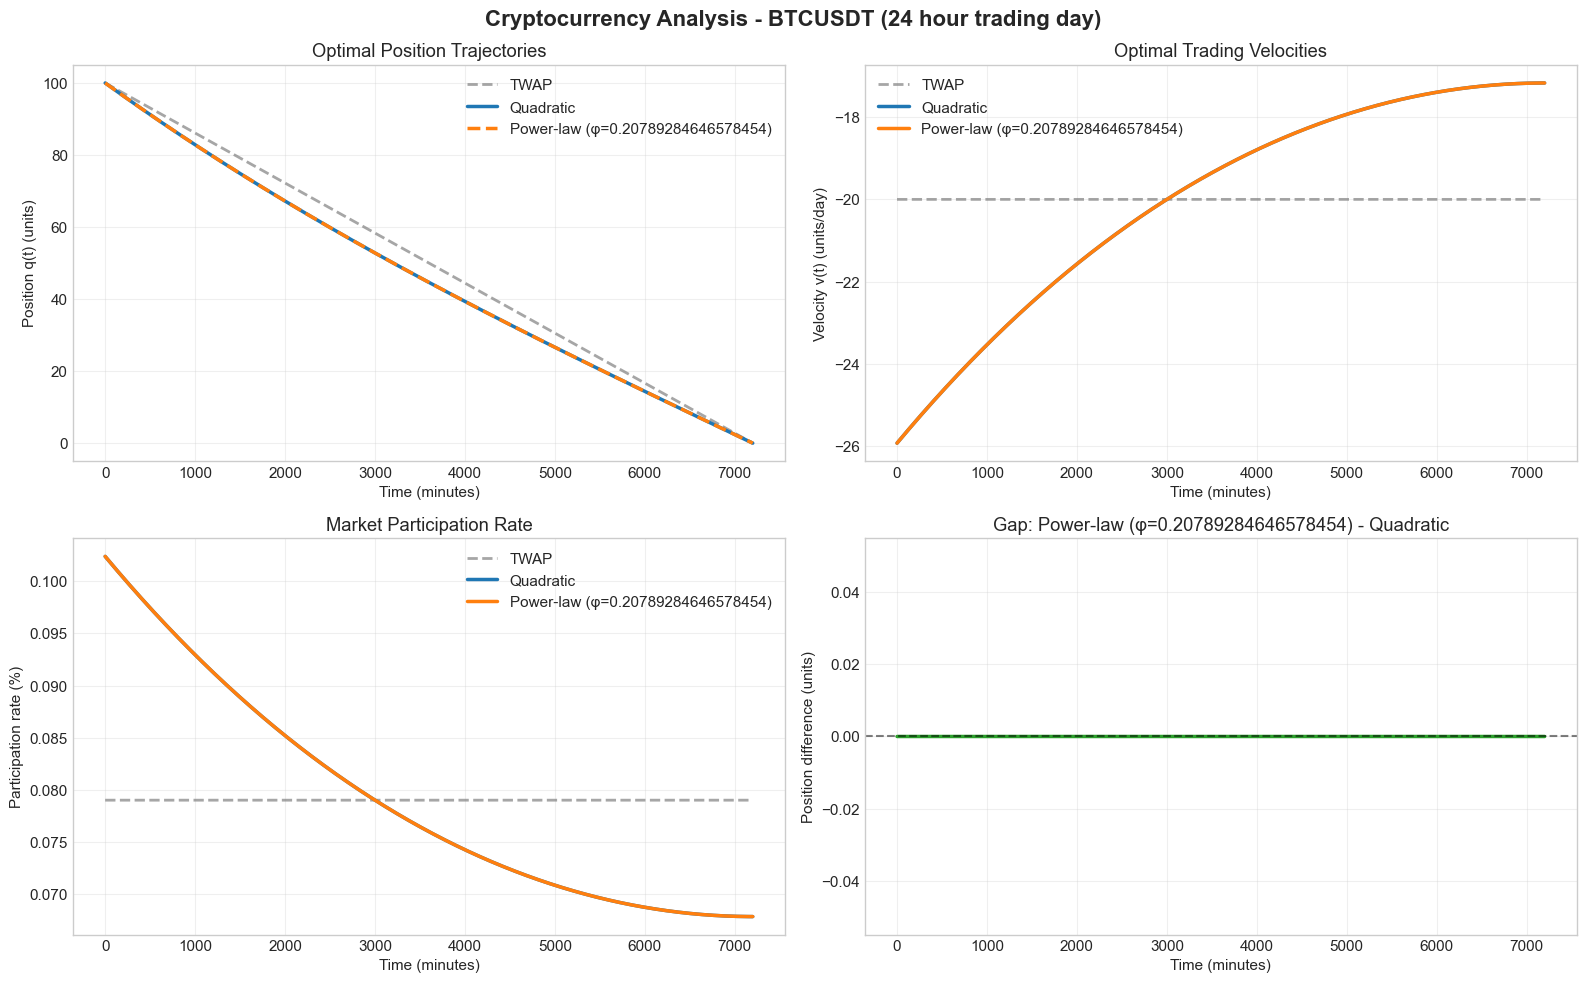

In [109]:
if crypto_available:
    # Visualization of trajectories for crypto
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Cryptocurrency Analysis - {SYMBOL_CRYPTO} (24 hour trading day)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Position q(t)
    ax = axes[0, 0]
    ax.plot(t_twap_crypto * 1440, q_twap_crypto, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_crypto * 1440, q_quad_crypto, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_crypto * 1440, q_power_crypto, '--', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_crypto})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position q(t) (units)')
    ax.set_title('Optimal Position Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Velocity v(t)
    ax = axes[0, 1]
    ax.plot(t_twap_crypto * 1440, v_twap_crypto, '--', color='gray', 
            linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_crypto * 1440, v_quad_crypto, '-', color='tab:blue', 
            linewidth=2.5, label='Quadratic')
    ax.plot(t_power_crypto * 1440, v_power_crypto, '-', color='tab:orange', 
            linewidth=2.5, label=f'Power-law (φ={phi_crypto})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Velocity v(t) (units/day)')
    ax.set_title('Optimal Trading Velocities')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Participation rate |v|/V
    ax = axes[1, 0]
    ax.plot(t_twap_crypto * 1440, np.abs(v_twap_crypto) / V_crypto * 100, '--', 
            color='gray', linewidth=2, alpha=0.7, label='TWAP')
    ax.plot(t_quad_crypto * 1440, np.abs(v_quad_crypto) / V_crypto * 100, '-', 
            color='tab:blue', linewidth=2.5, label='Quadratic')
    ax.plot(t_power_crypto * 1440, np.abs(v_power_crypto) / V_crypto * 100, '-', 
            color='tab:orange', linewidth=2.5, label=f'Power-law (φ={phi_crypto})')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Participation rate (%)')
    ax.set_title('Market Participation Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Difference between models
    ax = axes[1, 1]
    diff_position_crypto = q_power_crypto - q_quad_crypto
    ax.plot(t_power_crypto * 1440, diff_position_crypto, '-', color='tab:green', linewidth=2.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Position difference (units)')
    ax.set_title(f'Gap: Power-law (φ={phi_crypto}) - Quadratic')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 2.4 Cost Analysis for Crypto

In [110]:
if crypto_available:
    # Calculate costs for crypto
    print("Computing costs for crypto...\n")
    
    costs_quad_opt_crypto = model_quad_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
    costs_quad_twap_crypto = model_quad_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'twap')
    
    costs_power_opt_crypto = model_power_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
    costs_power_twap_crypto = model_power_crypto.compute_costs(q0_crypto, T_crypto, N_crypto, 'twap')
    
    # Create comparison DataFrame
    costs_comparison_crypto = pd.DataFrame({
        'Quadratic\nOptimal': [
            costs_quad_opt_crypto['execution_cost'] * S0_crypto,
            costs_quad_opt_crypto['permanent_impact'] * S0_crypto,
            costs_quad_opt_crypto['timing_risk'] * S0_crypto,
            costs_quad_opt_crypto['total_cost'] * S0_crypto
        ],
        'Quadratic\nTWAP': [
            costs_quad_twap_crypto['execution_cost'] * S0_crypto,
            costs_quad_twap_crypto['permanent_impact'] * S0_crypto,
            costs_quad_twap_crypto['timing_risk'] * S0_crypto,
            costs_quad_twap_crypto['total_cost'] * S0_crypto
        ],
        f'Power-law (φ={phi_crypto})\nOptimal': [
            costs_power_opt_crypto['execution_cost'] * S0_crypto,
            costs_power_opt_crypto['permanent_impact'] * S0_crypto,
            costs_power_opt_crypto['timing_risk'] * S0_crypto,
            costs_power_opt_crypto['total_cost'] * S0_crypto
        ],
        f'Power-law (φ={phi_crypto})\nTWAP': [
            costs_power_twap_crypto['execution_cost'] * S0_crypto,
            costs_power_twap_crypto['permanent_impact'] * S0_crypto,
            costs_power_twap_crypto['timing_risk'] * S0_crypto,
            costs_power_twap_crypto['total_cost'] * S0_crypto
        ]
    }, index=['Execution (€)', 'Permanent impact (€)', 'Timing risk (€)', 'Total (€)'])
    
    print("Cost comparison for crypto (in euros):")
    print(costs_comparison_crypto.round(2))
    
    # Costs in bps
    notional_crypto = abs(q0_crypto) * S0_crypto
    costs_bps_crypto = costs_comparison_crypto / notional_crypto * 10000
    print("\nCost comparison for crypto (in bps):")
    print(costs_bps_crypto.round(2))

Computing costs for crypto...

   ⚠️ BVP solver struggled with small ψ=0.000050
      Using quadratic approximation (ignoring ψ term)
Cost comparison for crypto (in euros):
                      Quadratic\nOptimal  Quadratic\nTWAP  \
Execution (€)                       0.13             0.13   
Permanent impact (€)               25.08            25.08   
Timing risk (€)                   904.31          1016.81   
Total (€)                         929.51          1042.01   

                      Power-law (φ=0.20789284646578454)\nOptimal  \
Execution (€)                                          928478.35   
Permanent impact (€)                                       25.08   
Timing risk (€)                                           904.31   
Total (€)                                              929407.73   

                      Power-law (φ=0.20789284646578454)\nTWAP  
Execution (€)                                       926404.86  
Permanent impact (€)                                

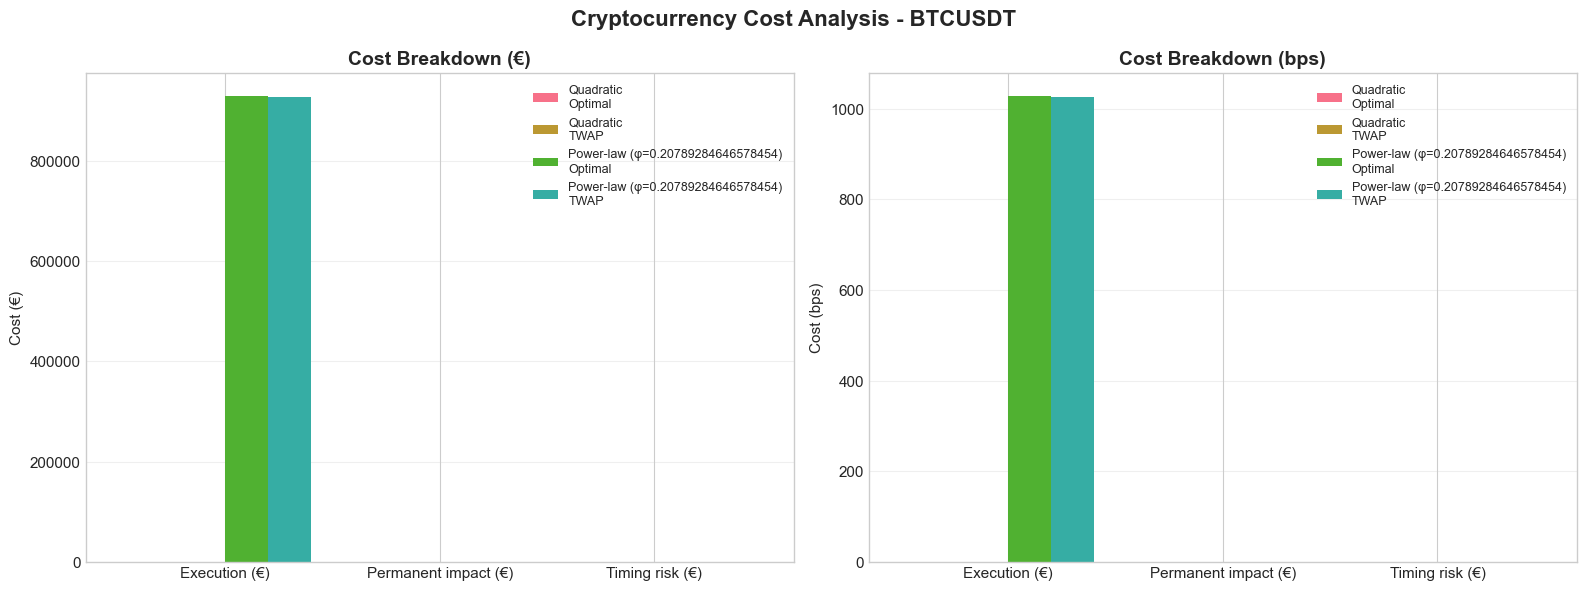


Optimization gains for crypto (Optimal vs TWAP):
   Quadratic model: 10.80%
   Power-law model (φ=0.20789284646578454): -0.21%

Difference between models for crypto (Optimal):
   Total cost: +99888.52%
   Execution cost: +715775820.00%


In [111]:
if crypto_available:
    # Visualization of costs for crypto
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Cryptocurrency Cost Analysis - {SYMBOL_CRYPTO}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Costs in euros
    ax = axes[0]
    costs_comparison_crypto.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Cost Breakdown (€)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cost (€)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    # 2. Costs in bps
    ax = axes[1]
    costs_bps_crypto.iloc[:-1].plot(kind='bar', ax=ax, width=0.8)
    ax.set_title('Cost Breakdown (bps)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cost (bps)')
    ax.set_xlabel('')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Optimization gains vs TWAP
    print("\nOptimization gains for crypto (Optimal vs TWAP):")
    gain_quad_crypto = (costs_quad_twap_crypto['total_cost'] - costs_quad_opt_crypto['total_cost']) / costs_quad_twap_crypto['total_cost'] * 100
    gain_power_crypto = (costs_power_twap_crypto['total_cost'] - costs_power_opt_crypto['total_cost']) / costs_power_twap_crypto['total_cost'] * 100
    
    print(f"   Quadratic model: {gain_quad_crypto:.2f}%")
    print(f"   Power-law model (φ={phi_crypto}): {gain_power_crypto:.2f}%")
    
    # Difference between models
    print("\nDifference between models for crypto (Optimal):")
    diff_total_crypto = (costs_power_opt_crypto['total_cost'] - costs_quad_opt_crypto['total_cost']) / costs_quad_opt_crypto['total_cost'] * 100
    diff_exec_crypto = (costs_power_opt_crypto['execution_cost'] - costs_quad_opt_crypto['execution_cost']) / costs_quad_opt_crypto['execution_cost'] * 100
    
    print(f"   Total cost: {diff_total_crypto:+.2f}%")
    print(f"   Execution cost: {diff_exec_crypto:+.2f}%")

## 2.5 Sensitivity Analysis on φ for Crypto

In [112]:
if crypto_available:
    # Test different values of φ for crypto
    phi_values = [0.3, 0.4, 0.5, 0.6, 0.7, 1.0]  # 1.0 = quadratic
    results_phi_crypto = []
    
    print("Sensitivity analysis on φ for crypto...\n")
    
    for phi_test in phi_values:
        print(f"   Computing for φ = {phi_test}...")
        
        model_test = AlmgrenChrissPowerLaw(
            lambda_risk=params_crypto_dict['lambda_risk'],
            sigma=params_crypto_dict['sigma'],
            k=params_crypto_dict['k'],
            phi=phi_test,
            eta=params_crypto_dict['eta'],
            psi=params_crypto_dict['psi'],
            V=params_crypto_dict['V']
        )
        
        try:
            t_test, q_test, v_test = model_test.optimal_trajectory(q0_crypto, T_crypto, N_crypto)
            costs_test = model_test.compute_costs(q0_crypto, T_crypto, N_crypto, 'optimal')
            
            results_phi_crypto.append({
                'phi': phi_test,
                'v_initial': v_test[0],
                'v_final': v_test[-1],
                'participation_initial': abs(v_test[0]) / V_crypto * 100,
                'participation_final': abs(v_test[-1]) / V_crypto * 100,
                'execution_cost': costs_test['execution_cost'] * S0_crypto,
                'total_cost': costs_test['total_cost'] * S0_crypto,
                'total_cost_bps': costs_test['total_cost'] / abs(q0_crypto) * 10000
            })
        except Exception as e:
            print(f"      Failed for φ = {phi_test}: {str(e)}")
    
    df_phi_crypto = pd.DataFrame(results_phi_crypto)
    
    print("\nResults for crypto:")
    print(df_phi_crypto[['phi', 'participation_initial', 'participation_final', 'total_cost_bps']].round(2))

Sensitivity analysis on φ for crypto...

   Computing for φ = 0.3...
   Computing for φ = 0.4...
   Computing for φ = 0.5...
   Computing for φ = 0.6...
   Computing for φ = 0.7...
   Computing for φ = 1.0...

Results for crypto:
   phi  participation_initial  participation_final  total_cost_bps
0  0.3                   0.08                 0.08          532.08
1  0.4                   0.08                 0.08          261.30
2  0.5                   0.08                 0.08          128.75
3  0.6                   0.08                 0.08           63.86
4  0.7                   0.09                 0.07           32.10
5  1.0                   0.12                 0.06            5.21


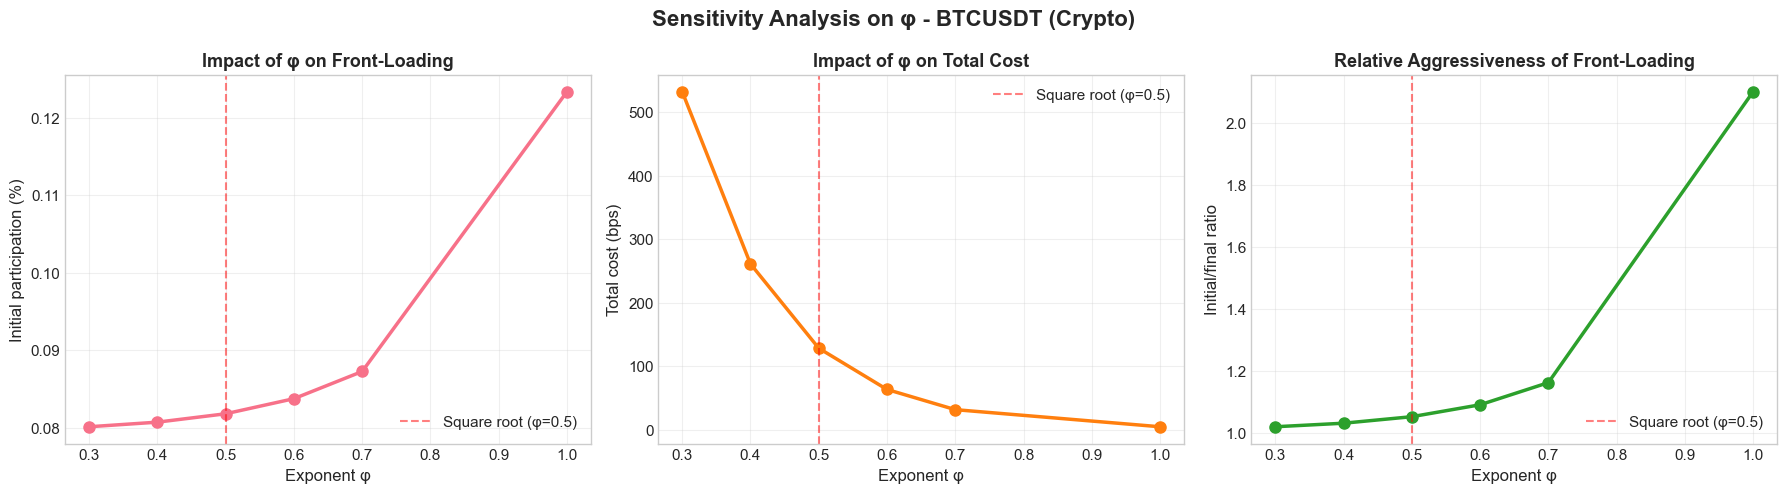


Observations for crypto:
   - Smaller φ → More aggressive front-loading (higher initial participation)
   - φ = 0.5 (square root): Empirically validated compromise
   - φ = 1.0 (quadratic): Classical Almgren-Chriss model


In [113]:
if crypto_available:
    # Sensitivity visualization for crypto
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Sensitivity Analysis on φ - {SYMBOL_CRYPTO} (Crypto)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Initial participation vs φ
    ax = axes[0]
    ax.plot(df_phi_crypto['phi'], df_phi_crypto['participation_initial'], 'o-', linewidth=2.5, markersize=8)
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial participation (%)', fontsize=12)
    ax.set_title('Impact of φ on Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Total cost vs φ
    ax = axes[1]
    ax.plot(df_phi_crypto['phi'], df_phi_crypto['total_cost_bps'], 'o-', linewidth=2.5, markersize=8, color='tab:orange')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Total cost (bps)', fontsize=12)
    ax.set_title('Impact of φ on Total Cost', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Initial/final participation ratio vs φ
    ax = axes[2]
    ratio_crypto = df_phi_crypto['participation_initial'] / df_phi_crypto['participation_final']
    ax.plot(df_phi_crypto['phi'], ratio_crypto, 'o-', linewidth=2.5, markersize=8, color='tab:green')
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Square root (φ=0.5)')
    ax.set_xlabel('Exponent φ', fontsize=12)
    ax.set_ylabel('Initial/final ratio', fontsize=12)
    ax.set_title('Relative Aggressiveness of Front-Loading', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nObservations for crypto:")
    print(f"   - Smaller φ → More aggressive front-loading (higher initial participation)")
    print(f"   - φ = 0.5 (square root): Empirically validated compromise")
    print(f"   - φ = 1.0 (quadratic): Classical Almgren-Chriss model")

---

# Summary & Comparison

## Key Observations:

1. **Power-law vs quadratic model**:
   - The power-law model (φ=0.5) better reflects the empirical concavity of market impact
   - Significant differences in front-loading and execution costs

2. **Empirical Calibration**:
   - φ = 0.5 (square root): Broad consensus in literature (Almgren+ 2005, Kyle & Obizhaeva 2016)
   - Linear permanent impact (k): Only choice without arbitrage (Huberman & Stanzl 2004)

3. **Stock vs Crypto Differences**:
   - **Trading hours**: 6.5 hours (stocks) vs 24 hours (crypto)
   - **Volatility**: Typically lower for stocks, higher for crypto
   - **Volume patterns**: U-shaped (stocks) vs more uniform (crypto)
   - **Position size**: 200k shares (stocks) vs 100 units (crypto)

4. **Practical Implications**:
   - More pronounced front-loading with sub-quadratic costs
   - Importance of empirical calibration for realistic predictions
   - Trade-off between model precision and solution complexity

## Recommendations:

1. **For Research**:
   - Use φ ∈ [0.4, 0.6] based on empirical literature
   - Calibrate on real execution data
   - Test parameter sensitivity

2. **For Production**:
   - Start with φ = 0.5 (square root law)
   - Adjust based on market characteristics
   - Validate on out-of-sample data

3. **Future Extensions**:
   - Non-constant intraday volume (U-shaped curve)
   - Resilient impact (temporal decay)
   - Multi-asset execution with correlations

## Save Results

In [114]:
# Save results
import os
os.makedirs('results', exist_ok=True)

results_dict = {
    'literature_references': {
        'phi_range': [0.4, 0.7],
        'phi_recommended': 0.5,
        'sources': [
            'Almgren et al. (2005) - Direct Estimation of Equity Market Impact',
            'Kyle & Obizhaeva (2016) - Market Microstructure Invariance',
            'Bacry et al. (2015) - Market Impact: Empirical Evidence',
            'Guéant (2016) - Financial Mathematics of Market Liquidity'
        ]
    }
}

if stocks_available:
    results_dict['stock_parameters'] = params_stock_dict
    results_dict['stock_quadratic_model'] = {
        'trajectory': {
            't': t_quad_stock.tolist(),
            'q': q_quad_stock.tolist(),
            'v': v_quad_stock.tolist()
        },
        'costs': costs_quad_opt_stock
    }
    results_dict['stock_power_law_model'] = {
        'trajectory': {
            't': t_power_stock.tolist(),
            'q': q_power_stock.tolist(),
            'v': v_power_stock.tolist()
        },
        'costs': costs_power_opt_stock
    }
    results_dict['stock_sensitivity_phi'] = df_phi_stock.to_dict('records')

if crypto_available:
    results_dict['crypto_parameters'] = params_crypto_dict
    results_dict['crypto_quadratic_model'] = {
        'trajectory': {
            't': t_quad_crypto.tolist(),
            'q': q_quad_crypto.tolist(),
            'v': v_quad_crypto.tolist()
        },
        'costs': costs_quad_opt_crypto
    }
    results_dict['crypto_power_law_model'] = {
        'trajectory': {
            't': t_power_crypto.tolist(),
            'q': q_power_crypto.tolist(),
            'v': v_power_crypto.tolist()
        },
        'costs': costs_power_opt_crypto
    }
    results_dict['crypto_sensitivity_phi'] = df_phi_crypto.to_dict('records')

with open('results/almgren_chriss_power_law_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=float)

print("✅ Results saved to 'results/almgren_chriss_power_law_results.json'")

✅ Results saved to 'results/almgren_chriss_power_law_results.json'
